In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stops = stopwords.words('french')
import re
import matplotlib.pyplot as plt
from collections import Counter, defaultdict 
from IPython.display import display
import numpy as np

from keras.models import Sequential, Model

[nltk_data] Downloading package punkt to /home/brice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of typ

### Préparation data et présentation data

In [2]:
data = pd.read_csv('../data/dataset_1.csv')
data=data.dropna()
data.head(2)

,Unnamed: 0,zip_code,problem,solution
0,1,57000.0,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...
1,5,95330.0,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...


In [3]:
def zip_count(data):
    zip_counts =  Counter()
    for code in data['zip_code'].values:
        zip_counts[code]+=1
    df=pd.DataFrame({'zip_code': list(dict(zip_counts).keys()), 'freq': list(dict(zip_counts).values())})
    df=df.sort_values(by=['freq'],ascending=False)
    return df

In [4]:
df=zip_count(data)
z=[n//1000 for n in df['zip_code'].values]
df['dpt']=z
df.head(4)

,zip_code,freq,dpt
150,75015.0,492,75.0
114,75012.0,337,75.0
191,75017.0,337,75.0
54,75020.0,309,75.0


In [5]:
df['dpt'].values

array([7.50000e+01, 7.50000e+01, 7.50000e+01, ..., 6.35905e+05,
       6.80000e+01, 1.00000e+00])

In [6]:
def f(data):
    d=dict()
    for x in data['dpt'].values:
        d[str(x)]=0
        for k in range(len(data)):
            if data['dpt'].values[k]==x:
                d[str(x)]+=data['freq'].values[k]
    return d        


In [7]:
dictio=f(df)
dff=pd.DataFrame({'dpt': list(dictio.keys()), 'freq': list(dictio.values())})

In [8]:
dff=dff.sort_values(by=['freq'],ascending=False)
dff.head(3)

,dpt,freq
0,75.0,4277
7,69.0,2937
11,92.0,2560


In [9]:
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
tokenizer.tokenize('je n\'sais pas !')

['je', "n'", 'sais', 'pas', '!']

In [10]:
#punctuation = re.compile('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]')
http = re.compile(r'http\S+')
www=re.compile(r'www.\S+')

from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
def text_prepare(text):
    text = text.lower() # min
    text=re.sub(r'<[^>]*>','',text)
    text=http.sub('', text) # suppr http...
    text=www.sub('',text) # suppr www...
#   text = punctuation.sub(' ', text) # suppr punct

    return text
    
def prepare_data2(dataset):
    problem=[]
    solution=[]
    zip_code=[]
    for k in range(dataset.shape[0]):
        problem.append(text_prepare(dataset['problem'].values[k]))
        solution.append(text_prepare(dataset['solution'].values[k]))
        zip_code.append(int(dataset['zip_code'].values[k]))        
    df=pd.DataFrame({'zip_code':zip_code, 'problem': problem, 'solution': solution})
    return df

In [11]:
data2=prepare_data2(data)

In [12]:
#afficher les mots dans la base de données avec leur nombre d'apparition

def word_num(dict):
    h=[]
    u=[]
    for x in dict.items():
        h.append(x[0])
        u.append(x[1])
    return h,u 
def word_count(data,s):
    tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
    lines=list(data['solution'])
    words_counts =  defaultdict(int)
    
    lines_T=[tokenizer.tokenize(line) for line in lines]
    for text in lines_T:
        for word in text:
            if s==False:
                if len(word)>1 : words_counts[word] += 1
            else:
                if len(word)>1 and word not in stops: words_counts[word] += 1
    word_filtered,num_filtered=word_num(words_counts)
    df= pd.DataFrame(num_filtered,index = word_filtered,columns = ['nombre'])
    df=df.sort_values(by=['nombre'],ascending=False)
    return df

In [13]:
stops[:10]

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']

In [14]:
df=word_count(data2,False)    #FAlse on laisse les stopwords, True on les supprime
df.head()

,nombre
de,369941
les,279454
et,214332
des,198588
la,195137


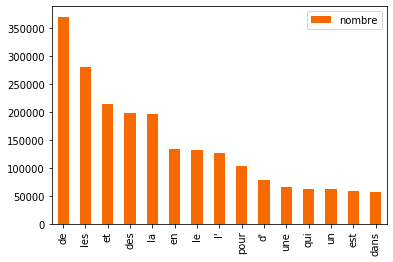

In [15]:
df[:15].plot(kind='bar', color="#f56900")

In [16]:
df2=word_count(data2,True)
df2.head()

,nombre
l',126380
d',78171
plus,56016
être,23493
produits,22941


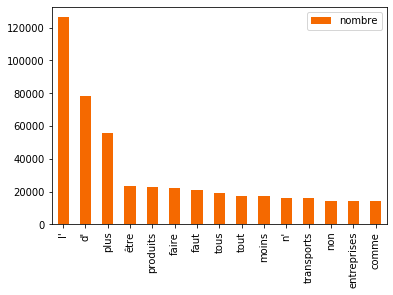

In [17]:
df2[:15].plot(kind='bar', color="#f56900")

In [18]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stops,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
show_wordcloud(list(data2['solution']))

### Entrainement d'un model

In [19]:
data_train = pd.read_csv('../data/data_F.csv', sep=';')
data_train.head(2)

,zip_code,problem,solution,annotation
0,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,1.0
1,95330,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...,1.0


In [20]:
def zip_count(data):
    zip_counts =  Counter()
    for code in data['zip_code'].values:
        zip_counts[code]+=1
    df=pd.DataFrame({'zip_code': list(dict(zip_counts).keys()), 'freq': list(dict(zip_counts).values())})
    df=df.sort_values(by=['freq'],ascending=False)
    return df


In [21]:
df=zip_count(data_train)
df.head(4)

,zip_code,freq
111,44000,15
150,75015,14
148,75014,13
191,75017,13


In [22]:
#punctuation = re.compile('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]')
http = re.compile(r'http\S+')
www=re.compile(r'www.\S+')

from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
def text_prepare(text):
    text = text.lower() # min
    text=re.sub(r'<[^>]*>','',text)
    text=http.sub('', text) # suppr http...
    text=www.sub('',text) # suppr www...
#   text = punctuation.sub(' ', text) # suppr punct

    return text
    
def prepare_data2(dataset):
    problem=[]
    solution=[]
    zip_code=[]
    annotation=[]
    for k in range(dataset.shape[0]):
        problem.append(text_prepare(dataset['problem'].values[k]))
        solution.append(text_prepare(dataset['solution'].values[k]))
        zip_code.append(int(dataset['zip_code'].values[k]))
        annotation.append(int(dataset['annotation'].values[k]))
        
    df=pd.DataFrame({'zip_code':zip_code, 'problem': problem, 'solution': solution, 'annotation':annotation })
    return df

In [23]:
data_train2=prepare_data2(data_train)

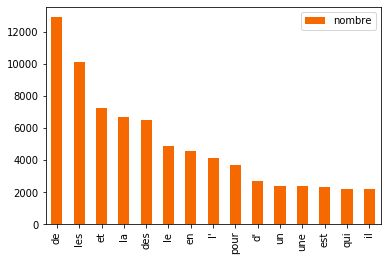

In [24]:
df=word_count(data_train2,False)    #FAlse on laisse les stopwords, True on les supprime
df[:15].plot(kind='bar', color="#f56900")

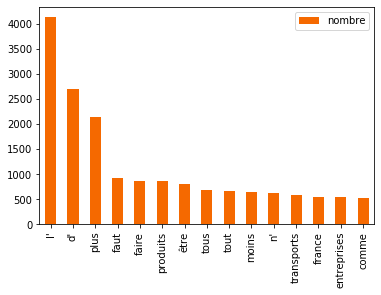

In [25]:
df2=word_count(data_train2,True)
df2[:15].plot(kind='bar', color="#f56900")

In [26]:
show_wordcloud(list(data_train2['solution']))

NameError: name 'show_wordcloud' is not defined

In [27]:
X, y = data_train2['solution'], data_train2['annotation']
from keras.utils import to_categorical
y_binary = to_categorical(y)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [34]:
print('{:.2e}'.format(0.1212))

1.21e-01


In [29]:
voc=word_count(data_train2,False)
len(voc)

16598

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer2 = Tokenizer(nb_words=20000, filters='\n',
                                   lower=True,split=' ')
tokenizer2.fit_on_texts(X_train)
X_train2 = tokenizer2.texts_to_sequences(X_train)
X_train2 = pad_sequences(X_train2)

X_test2 = tokenizer2.texts_to_sequences(X_test)
X_test2 = pad_sequences(X_test2,maxlen=X_train2.shape[1])

print(X_train2.shape,y_train_binary.shape)
print(X_test2.shape,y_test_binary.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(1956, 5114) (1956, 2)
(489, 5114) (489, 2)


In [31]:
embed_dim = 512
lstm_out = 128
batch_size = 32

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(20000, embed_dim,input_length = X_train2.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  if __name__ == '__main__':


In [32]:
hist=model.fit(X_train2, y_train_binary, validation_data=(X_test2,y_test_binary), batch_size = batch_size, verbose = 1, epochs=10)
score=max(hist.history['val_acc'])


Train on 1956 samples, validate on 489 samples
Epoch 1/10
1956/1956 [==============================] - 791s 404ms/step - loss: 0.6149 - accuracy: 0.6779 - val_loss: 0.5072 - val_accuracy: 0.7321
Epoch 2/10
1568/1956 [=======================>......] - ETA: 2:17 - loss: 0.3796 - accuracy: 0.8412

KeyboardInterrupt: 

In [ ]:
model.save('models/model.h5')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test2, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test_binary, axis=1)
print(classification_report(y_test, y_pred_bool))

In [ ]:
def pred(data):
    X=data['solution'].values
    X = tokenizer2.texts_to_sequences(X)
    X = pad_sequences(X,maxlen=X_train2.shape[1])
    y_pred=model.predict(X, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    data['annotation']=y_pred
    return data

In [ ]:
result=pred(data2)

In [ ]:
result.to_csv('data/result.csv', index=False, sep=';')

In [ ]:
result.head(3)

In [ ]:
dpts = [k for k in range(1,21)] + [20] + [k for k in range(21,96)]

def f(data):
    d=dict()
    for x in dpts:
        d[str(x)]=0
        for k in range(len(data)):
            if data['zip_code'].values[k]//1000==x:
                d[str(x)]+=data['annotation'].values[k]
    return d        


In [ ]:
resultF=f(result)

In [ ]:
df_result=pd.DataFrame({'dpt': list(resultF.keys()), 'freq': list(resultF.values())})
df_result=df_result.sort_values(by=['freq'],ascending=False)

In [ ]:
df_result.index=df_result['dpt']
df_result.head(4)

In [ ]:
df_result[:15].plot(kind='bar', color="#f56900")
# a centrer dans la suite...

In [ ]:
import cartopy.crs as ccrs
import geoplot

dpts = [k for k in range(1,21)] + [20] + [k for k in range(21,96)]
Colors = list(df_result['freq'].values)
Colors = pd.DataFrame(Colors, index=list(df_result['dpt'].values), columns=['colors'])

plot_cartography(Colors, eval_type, figsize=(14,14))